In [1]:
from ultralytics import YOLO

In [2]:
yolo_model_path = '/Users/francesco/repos/computer_vision_project/app_dev/assets/yolo11n_float32.tflite'
img_path = '/Users/francesco/repos/computer_vision_project/IMG_0288.jpg'

model = YOLO(yolo_model_path, task='detect')


results = model.predict(
    source=str(img_path),
    imgsz=608,
    conf=0.5,
    save=False,
    device='cpu',
    verbose=False
)
print("Prediction Results:")
for result in results:
    print(f"Bounding Boxes: {result.boxes.xyxy}")  # Bounding box coordinates
    print(f"Confidences: {result.boxes.conf}")   # Confidence scores
    print(f"Classes: {result.boxes.cls}")

Loading /Users/francesco/repos/computer_vision_project/app_dev/assets/yolo11n_float32.tflite for TensorFlow Lite inference...


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Prediction Results:
Bounding Boxes: tensor([], size=(0, 4))
Confidences: tensor([])
Classes: tensor([])


In [8]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='/Users/francesco/repos/computer_vision_project/app_dev/assets/skc_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
image = Image.open('/Users/francesco/repos/computer_vision_project/app_dev/assets/malignant_test_image.jpg').resize((224, 224))
input_data = np.asarray(image).astype('float32') / 255.0  # Normalize to [0, 1]
input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension (shape: [1, 224, 224, 3])

# Check input tensor shape
print("Input tensor shape:", input_details[0]['shape'])  # Should print [1, 224, 224, 3]

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)  # Pass 4D tensor (not flattened)
interpreter.invoke()

# Get output
output = interpreter.get_tensor(output_details[0]['index'])
print("Model output:", output)  # Prints the risk score or prediction


Input tensor shape: [  1 224 224   3]
Model output: [[    0.13139]]


In [ ]:
def process_single_image(self, img_path, save_crops=False):
        try:
            results = self.model.predict(
                source=str(img_path),
                imgsz=self.imgsz,
                conf=self.conf_threshold,
                save=False,
                device='cpu',
                verbose=False
            )
            original_img = cv2.imread(str(img_path))
            if original_img is None:
                print(f"Could not read image: {img_path}")
                return None
            
            img_height, img_width = original_img.shape[:2]
 
            for result in results:
                boxes = result.boxes
                if len(boxes) > 0:
                    confidences = [box.conf.item() for box in boxes]
                    best_idx = np.argmax(confidences)
                    box = boxes[best_idx]
                    
                    if box.conf.item() > self.conf_threshold:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

                        class_id = box.cls.item()

                        cropped_img = original_img[y1:y2, x1:x2]
                        
                        # Uncomment for the pipeline test
                        output_stem = f"{Path(img_path).stem}_det_cls{int(class_id)}_conf{box.conf.item():.2f}"
                        output_path = self.output_dir / f"{output_stem}_original.jpg"
                        
                        # Uncomment to create a dataset processed by yolo
                        # output_stem = f"{Path(img_path).stem}"
                        # output_path = self.output_dir / f"{output_stem}.jpg"
                        cv2.imwrite(str(output_path), cropped_img)  
                        return str(output_path)
                    else:
                        print(f"Image {img_path} has confidence {box.conf.item()} which is below the threshold {self.conf_threshold}")
                else:
                    print(f"No detections found for {img_path}")
                    return None
            return None 

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            return None

Loading /Users/francesco/repos/computer_vision_project/app_dev/assets/yolo11n_float32.tflite for TensorFlow Lite inference...


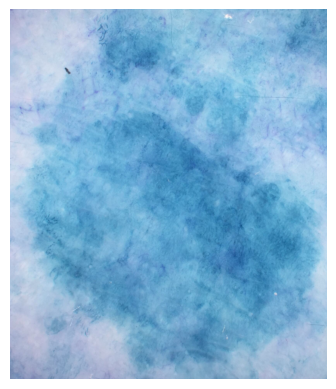

Mole detected with confidence 0.8356438875198364
Bounding Box: x1=627, y1=447, x2=2266, y2=2363
Image shape = (1916, 1639, 3)
Original Image shape = (2448, 3264, 3)
Input tensor shape: [  1 224 224   3]
Model output: [[    0.78518]]


In [50]:
import cv2
import matplotlib.pyplot
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO


yolo_model_path = '/Users/francesco/repos/computer_vision_project/app_dev/assets/yolo11n_float32.tflite'
img_path = '/Users/francesco/repos/computer_vision_project/app_dev/assets/malignant_test_image.jpg'
conf_threshold = 0.5

model = YOLO(yolo_model_path, task='detect')
results = model.predict(
                source=str(img_path),
                imgsz=608,
                conf=conf_threshold,
                save=False,
                device='cpu',
                verbose=False
            )
original_img = cv2.imread(str(img_path))

img_height, img_width = original_img.shape[:2]

for result in results:
    boxes = result.boxes
    if len(boxes) > 0:
        confidences = [box.conf.item() for box in boxes]
        best_idx = np.argmax(confidences)
        box = boxes[best_idx]
        
        if box.conf.item() > conf_threshold:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

            class_id = box.cls.item()

            cropped_img = original_img[y1:y2, x1:x2]
            plt.imshow(cropped_img)
            plt.axis('off')
            plt.show()
            print(f"Mole detected with confidence {box.conf.item()}")
            print(f"Bounding Box: x1={x1}, y1={y1}, x2={x2}, y2={y2}")
            print(f"Image shape = {cropped_img.shape}")
            print(f"Original Image shape = {original_img.shape}")
        else:
            print(f"Image {img_path} has confidence {box.conf.item()} which is below the threshold {self.conf_threshold}")
    else:
        print(f"No detections found for {img_path}")


# ------ PREPROCESS --------
img_tensor = tf.convert_to_tensor(cropped_img, dtype=tf.float32)
img = img_tensor / 255.0
img = tf.image.resize(img, [224, 224])
img = tf.expand_dims(img, axis=0)



# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='/Users/francesco/repos/computer_vision_project/app_dev/assets/skc_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# # Load and preprocess the image
# image = cropped_img.resize((224, 224))
# input_data = np.asarray(image).astype('float32') / 255.0  # Normalize to [0, 1]
# input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension (shape: [1, 224, 224, 3])

# Check input tensor shape
print("Input tensor shape:", input_details[0]['shape'])  # Should print [1, 224, 224, 3]

# Run inference
interpreter.set_tensor(input_details[0]['index'], img)  # Pass 4D tensor (not flattened)
interpreter.invoke()

# Get output
output = interpreter.get_tensor(output_details[0]['index'])
print("Model output:", output)  # Prints the risk score or prediction

# Pipeline with tflite implementation

Original image size: 3264x2448
Raw detection model output shape: (1, 5, 7581)
Decoded boxes shape: (10, 4)
Decoded scores shape: (10,)

Found 1 detections:
Best Detection:
  Confidence: 0.8412
  Bounding Box: x1=630, y1=429, x2=2263, y2=2363
  Width: 1632, Height: 1933


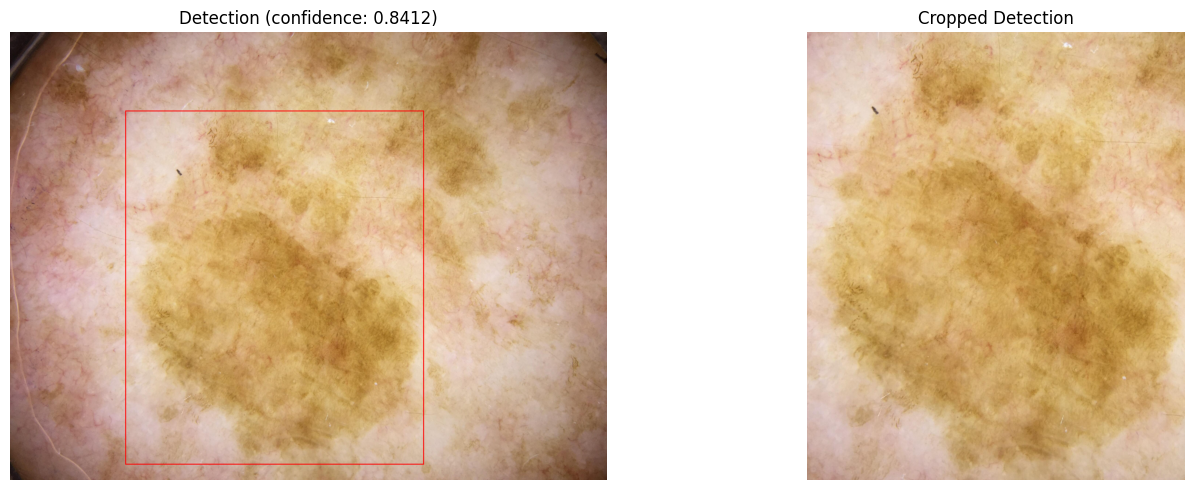

Classification model input shape: [  1 224 224   3]
Classification model output: [[    0.05146]]

Malignancy probability: 0.0515

Returned Malignancy Probability: 0.05145994946360588


In [54]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, img_size):
    """Load and preprocess image using OpenCV to match the working implementation."""
    # Use OpenCV to load image in BGR format
    image = cv2.imread(image_path)
    original_size = image.shape[:2]  # (height, width)
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize maintaining aspect ratio
    ratio = float(img_size) / max(original_size)
    new_size = tuple([int(x * ratio) for x in original_size])
    new_height, new_width = new_size
    
    # Resize using OpenCV
    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    
    # Create a black canvas and place the resized image
    new_image = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    dx = (img_size - new_width) // 2
    dy = (img_size - new_height) // 2
    new_image[dy:dy+new_height, dx:dx+new_width] = image
    
    # Convert to float32 and normalize
    np_image = np.array(new_image, dtype=np.float32) / 255.0
    
    scale_factors = {
        'original_size': (original_size[1], original_size[0]),  # (width, height)
        'new_size': (new_width, new_height),
        'padding': (dx, dy),
        'ratio': ratio
    }
    
    return np_image, scale_factors

def decode_predictions(output_data, conf_threshold, img_size=608, scale_factors=None):
    """Modified decoder to better match Ultralytics YOLO output processing."""
    predictions = np.transpose(output_data[0])
    
    # Extract scores (confidence)
    scores = predictions[:, 4]
    
    # Find predictions above threshold
    mask = scores > conf_threshold
    filtered_boxes = predictions[mask]
    filtered_scores = scores[mask]
    
    if len(filtered_boxes) > 0:
        # Extract normalized coordinates
        x = filtered_boxes[:, 0]
        y = filtered_boxes[:, 1]
        w = filtered_boxes[:, 2]
        h = filtered_boxes[:, 3]
        
        if scale_factors:
            original_width, original_height = scale_factors['original_size']
            pad_x, pad_y = scale_factors['padding']
            ratio = scale_factors['ratio']
            
            # Scale coordinates back to original image space
            x = (x * img_size - pad_x) / ratio
            y = (y * img_size - pad_y) / ratio
            w = (w * img_size) / ratio
            h = (h * img_size) / ratio
            
            # Convert to corner coordinates
            xmin = np.clip(x - w/2, 0, original_width)
            ymin = np.clip(y - h/2, 0, original_height)
            xmax = np.clip(x + w/2, 0, original_width)
            ymax = np.clip(y + h/2, 0, original_height)
        else:
            xmin = x - w/2
            ymin = y - h/2
            xmax = x + w/2
            ymax = y + h/2
        
        # Stack coordinates for NMS
        boxes = np.stack([ymin, xmin, ymax, xmax], axis=-1)
        return boxes.astype(np.float32), filtered_scores.astype(np.float32)
    else:
        return np.array([], dtype=np.float32), np.array([], dtype=np.float32)

def run_mole_classification(cropped_img):
    """Modified classification to match the working implementation."""
    # Convert BGR to RGB if needed
    if len(cropped_img.shape) == 3 and cropped_img.shape[2] == 3:
        if isinstance(cropped_img, np.ndarray):
            cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    
    # Convert to tensor and preprocess
    img_tensor = tf.convert_to_tensor(cropped_img, dtype=tf.float32)
    img = img_tensor / 255.0
    img = tf.image.resize(img, [224, 224])
    img = tf.expand_dims(img, axis=0)
    
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path='skc_model.tflite')
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Run inference
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    
    # Get output
    output = interpreter.get_tensor(output_details[0]['index'])
    return float(output[0][0])

def main(tflite_model_path, img_path, conf_threshold=0.5, iou_threshold=0.5):
    # Load and preprocess image
    image, scale_factors = load_and_preprocess_image(img_path, 608)
    
    # Run detection model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    input_data = np.expand_dims(image, axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Decode predictions
    boxes, scores = decode_predictions(output_data, conf_threshold, 608, scale_factors)
    
    if len(boxes) > 0:
        # Apply NMS
        selected_indices = tf.image.non_max_suppression(
            boxes=boxes,
            scores=scores,
            max_output_size=100,
            iou_threshold=iou_threshold,
            score_threshold=float('-inf')
        ).numpy()
        
        if len(selected_indices) > 0:
            # Get best detection
            best_idx = np.argmax(scores[selected_indices])
            best_box = boxes[selected_indices[best_idx]]
            best_score = scores[selected_indices[best_idx]]
            
            # Get coordinates
            ymin, xmin, ymax, xmax = map(int, best_box)
            
            # Load original image and crop
            original_img = cv2.imread(img_path)
            cropped_img = original_img[ymin:ymax, xmin:xmax]
            
            # Run classification
            malignancy_probability = run_mole_classification(cropped_img)
            
            print(f"Mole detected with confidence {best_score}")
            print(f"Bounding Box: x1={xmin}, y1={ymin}, x2={xmax}, y2={ymax}")
            print(f"Image shape = {cropped_img.shape}")
            print(f"Original Image shape = {original_img.shape}")
            
            # Display the cropped region
            plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
            
            return malignancy_probability
    
    print("No detections found")
    return None

if __name__ == '__main__':
    tflite_model_path = 'yolo11n_float32.tflite'
    img_path = 'malignant_test_image.jpg'
    
    result = main(tflite_model_path, img_path)
    print(f"Model output: [[{result}]]")

In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
import glob

##############################
# Detection and Classification Functions
##############################

def load_and_preprocess_image(image_path, img_size):
    """Load and preprocess image while keeping track of scaling factors."""
    image = Image.open(image_path)
    original_size = image.size  # (width, height)
    original_width, original_height = original_size

    # Calculate scale and padding
    ratio = float(img_size) / max(original_size)
    new_size = tuple([int(x * ratio) for x in original_size])
    new_width, new_height = new_size

    # Resize image
    image = image.resize(new_size, Image.Resampling.LANCZOS)

    # Create a black canvas and paste the resized image
    new_image = Image.new("RGB", (img_size, img_size), (0, 0, 0))
    dx = (img_size - new_width) // 2
    dy = (img_size - new_height) // 2
    new_image.paste(image, (dx, dy))

    # Convert to numpy array and normalize
    np_image = np.array(new_image) / 255.0

    # Calculate scaling factors for later
    scale_factors = {
        'original_size': original_size,
        'new_size': new_size,
        'padding': (dx, dy),
        'ratio': ratio
    }

    return np_image.astype(np.float32), scale_factors

def run_tflite_model(tflite_file, image):
    interpreter = tf.lite.Interpreter(model_path=tflite_file)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data = np.expand_dims(image, axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

def decode_predictions(output_data, conf_threshold, img_size=608, scale_factors=None):
    """
    Decode YOLO predictions and scale back to original image size.
    """
    # Reshape to (num_predictions, bbox_attrs) assuming bbox_attrs=5 here
    predictions = np.transpose(output_data[0])  # e.g., shape: (7581, 5)

    # Extract scores (confidence)
    scores = predictions[:, 4]

    # Find predictions above threshold
    mask = scores > conf_threshold
    filtered_boxes = predictions[mask]
    filtered_scores = scores[mask]

    if len(filtered_boxes) > 0:
        # Extract normalized coordinates (relative to 608x608)
        x = filtered_boxes[:, 0]  # center x
        y = filtered_boxes[:, 1]  # center y
        w = filtered_boxes[:, 2]  # width
        h = filtered_boxes[:, 3]  # height

        if scale_factors:
            original_width, original_height = scale_factors['original_size']
            pad_x, pad_y = scale_factors['padding']
            ratio = scale_factors['ratio']

            # Remove padding offset and scale back to original image dimensions
            x = (x * img_size - pad_x) / ratio
            y = (y * img_size - pad_y) / ratio
            w = (w * img_size) / ratio
            h = (h * img_size) / ratio

            # Convert to corner coordinates in original image space
            xmin = np.clip(x - w/2, 0, original_width)
            ymin = np.clip(y - h/2, 0, original_height)
            xmax = np.clip(x + w/2, 0, original_width)
            ymax = np.clip(y + h/2, 0, original_height)
        else:
            # Convert to corner coordinates in 608x608 space
            xmin = x - w/2
            ymin = y - h/2
            xmax = x + w/2
            ymax = y + h/2

        # Stack coordinates for NMS (ymin, xmin, ymax, xmax format)
        boxes = np.stack([ymin, xmin, ymax, xmax], axis=-1)
        return boxes.astype(np.float32), filtered_scores.astype(np.float32)
    else:
        return np.array([], dtype=np.float32), np.array([], dtype=np.float32)

def non_max_suppression(boxes, scores, iou_threshold):
    if len(boxes) == 0:
        return []
    
    boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
    scores_tensor = tf.convert_to_tensor(scores, dtype=tf.float32)
    
    selected_indices = tf.image.non_max_suppression(
        boxes=boxes_tensor,
        scores=scores_tensor,
        max_output_size=100,
        iou_threshold=iou_threshold,
        score_threshold=float('-inf')
    ).numpy()
    
    return selected_indices

def run_mole_classification(cropped_img, classification_model_path):
    """
    Run the classification model on the cropped image and return the malignancy probability.
    """
    # If the cropped image is a PIL Image, convert to numpy array
    if isinstance(cropped_img, Image.Image):
        cropped_img = np.array(cropped_img)

    # Convert image to tensor and preprocess
    img_tensor = tf.convert_to_tensor(cropped_img, dtype=tf.float32)
    img_tensor = img_tensor / 255.0  # Normalize to [0, 1]
    img_tensor = tf.image.resize(img_tensor, [224, 224])
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    # Load TFLite classification model
    interpreter = tf.lite.Interpreter(model_path=classification_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], img_tensor)
    interpreter.invoke()

    # Get output (assuming a single risk score is returned)
    output = interpreter.get_tensor(output_details[0]['index'])
    malignancy_probability = float(output[0][0])
    return malignancy_probability

def process_single_image(tflite_detection_model_path, classification_model_path, image_path, conf_threshold=0.5, iou_threshold=0.5, visualize=False):
    """
    Process one image: run detection, crop best detection, run classification,
    and return the predicted malignancy probability.
    """
    # Load and preprocess image for detection
    image, scale_factors = load_and_preprocess_image(image_path, 608)
    print(f"Processing image: {os.path.basename(image_path)}")
    
    # Run detection model
    output_data = run_tflite_model(tflite_detection_model_path, image)
    # Decode predictions
    boxes, scores = decode_predictions(output_data, conf_threshold, 608, scale_factors)
    
    malignancy_probability = None  # default if no detection

    if len(boxes) > 0:
        # Apply Non-Maximum Suppression (NMS)
        selected_indices = non_max_suppression(boxes, scores, iou_threshold)
        if len(selected_indices) > 0:
            selected_boxes = boxes[selected_indices]
            selected_scores = scores[selected_indices]
            # Choose the detection with highest confidence
            best_idx = np.argmax(selected_scores)
            best_box = selected_boxes[best_idx]
            best_score = selected_scores[best_idx]
            print(f"  Best detection confidence: {best_score:.4f}")
            # If visualization is requested, show detection; otherwise, crop directly
            if visualize:
                original_image = Image.open(image_path)
                image_with_box = original_image.copy()
                draw = ImageDraw.Draw(image_with_box)
                ymin_box, xmin_box, ymax_box, xmax_box = best_box
                draw.rectangle([xmin_box, ymin_box, xmax_box, ymax_box], outline='red', width=5)
                plt.imshow(image_with_box)
                plt.title(f"Detection confidence: {best_score:.4f}")
                plt.axis('off')
                plt.show()
                cropped_img = original_image.crop((xmin_box, ymin_box, xmax_box, ymax_box))
            else:
                original_image = Image.open(image_path)
                ymin_box, xmin_box, ymax_box, xmax_box = best_box
                cropped_img = original_image.crop((xmin_box, ymin_box, xmax_box, ymax_box))
            # Run classification on the cropped image
            malignancy_probability = run_mole_classification(cropped_img, classification_model_path)
            print(f"  Predicted malignancy probability: {malignancy_probability:.4f}")
        else:
            print("  No detections remain after applying NMS.")
    else:
        print("  No detections above the confidence threshold.")

    return malignancy_probability

##############################
# Batch Processing and Accuracy Calculation
##############################

def find_image_file(images_folder, image_base_name):
    """
    Given an images folder and an image base name (possibly without extension),
    try to find the actual file by checking common extensions.
    """
    # First, check if the file exists as provided.
    full_path = os.path.join(images_folder, image_base_name)
    if os.path.exists(full_path):
        return full_path

    # List of common extensions (you can add more if needed)
    extensions = ['.jpg', '.jpeg', '.png']
    for ext in extensions:
        candidate = os.path.join(images_folder, image_base_name + ext)
        if os.path.exists(candidate):
            return candidate

    # Also check if the base name already has an extension (e.g., missing a dot)
    for ext in extensions:
        if image_base_name.lower().endswith(ext):
            candidate = os.path.join(images_folder, image_base_name)
            if os.path.exists(candidate):
                return candidate

    return None

def evaluate_accuracy(tflite_detection_model_path, classification_model_path, images_folder, csv_file, conf_threshold=0.5, iou_threshold=0.5, visualize=False, prob_threshold=0.5):
    """
    Process all images listed in the CSV, compare predictions with ground truth,
    and print the overall accuracy.
    
    Parameters:
      - prob_threshold: the probability threshold for classifying as malignant.
      - The CSV is assumed to have:
          * "image_name": the image file name (or base name).
          * "target": the ground truth (1 for malignant, 0 for benign).
    """
    df = pd.read_csv(csv_file)
    
    total = 0
    correct = 0

    for idx, row in df.iterrows():
        image_base_name = row['image_name']
        # Use "target" column; change to "benign_malignant" if needed.
        ground_truth = row['target']
        
        # Try to find the actual image file
        image_path = find_image_file(images_folder, image_base_name)
        if image_path is None:
            print(f"Image not found: {os.path.join(images_folder, image_base_name)}")
            continue

        pred_prob = process_single_image(
            tflite_detection_model_path,
            classification_model_path,
            image_path,
            conf_threshold=conf_threshold,
            iou_threshold=iou_threshold,
            visualize=visualize
        )
        if pred_prob is None:
            print("  Skipping image due to no detection.")
            continue

        # Convert predicted probability to binary prediction.
        pred_label = 1 if pred_prob >= prob_threshold else 0

        total += 1
        if pred_label == ground_truth:
            correct += 1

    if total > 0:
        accuracy = correct / total * 100
        print("\n===================================")
        print(f"Processed {total} images.")
        print(f"Correct predictions: {correct}")
        print(f"Overall Accuracy: {accuracy:.2f}%")
    else:
        print("No images processed.")

##############################
# Example Usage
##############################

if __name__ == '__main__':
    # Paths to your models (update these paths if needed)
    tflite_detection_model_path = '/Users/francesco/repos/computer_vision_project/app_dev/assets/yolo11n_float32.tflite'
    classification_model_path = '/Users/francesco/repos/computer_vision_project/app_dev/assets/skc_model.tflite'
    
    # Folder and CSV file paths (update these paths if needed)
    images_folder = '/Users/francesco/repos/computer_vision_project/models_dev/dataset/ISIC2020/train/train_images'
    csv_file = '/Users/francesco/repos/computer_vision_project/models_dev/dataset/ISIC2020/train/ISIC_2020_Training_GroundTruth_v2.csv'
    
    # Evaluate the overall accuracy without saving any results.
    evaluate_accuracy(
        tflite_detection_model_path,
        classification_model_path,
        images_folder,
        csv_file,
        conf_threshold=0.5,
        iou_threshold=0.5,
        visualize=False,   # Set to True if you want to see the detections
        prob_threshold=0.5 # Threshold to decide malignant vs benign
    )


Processing image: ISIC_2637011.jpg
  Best detection confidence: 0.8247
  Predicted malignancy probability: 0.2775
Image not found: /Users/francesco/repos/computer_vision_project/models_dev/dataset/ISIC2020/train/train_images/ISIC_0015719
Processing image: ISIC_0052212.jpg
  Best detection confidence: 0.8783
  Predicted malignancy probability: 0.8481
Processing image: ISIC_0068279.jpg
  Best detection confidence: 0.8154
  Predicted malignancy probability: 0.3496
Processing image: ISIC_0074268.jpg
  Best detection confidence: 0.7831
  Predicted malignancy probability: 0.0851
Processing image: ISIC_0074311.jpg
  Best detection confidence: 0.8922
  Predicted malignancy probability: 0.4123
Processing image: ISIC_0074542.jpg
  Best detection confidence: 0.8861
  Predicted malignancy probability: 0.2174
Processing image: ISIC_0075663.jpg
  Best detection confidence: 0.8060
  Predicted malignancy probability: 0.1585
Processing image: ISIC_0075914.jpg
  Best detection confidence: 0.6544
  Predi

KeyboardInterrupt: 